# Machine Learning Workshop: Deep Dive into Regression and Optimization with PyTorch

This Jupyter Notebook is designed for university students who have a theoretical understanding of Linear Regression, Logistic Regression, and Gradient Descent. We will move from theory to practice by implementing these core concepts **from scratch** using PyTorch tensors, and then leveraging PyTorch's built-in modules for a more efficient, production-ready approach.

The primary goal is to visualize the learning process, understand the effect of different optimization strategies, and clearly demonstrate key concepts like overfitting, underfitting, and regularization.

## 1. Setup and Data Loading

We will use two classic, real-world datasets:
1.  **Ames Housing Dataset** (for Linear Regression)
2.  **Breast Cancer Wisconsin (Diagnostic) Dataset** (for Logistic Regression)

### 1.1. Import Libraries


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer, make_classification

### 1.2. Load and Prepare Data

#### 1.2.1. Linear Regression Data (Ames Housing - Simplified)

*Note: For simplicity and to focus on the core ML concepts, we will use a simplified version of the Ames Housing data, focusing on a few key features.*


All features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Training X shape: torch.Size([800, 2])
Testing  X shape: torch.Size([200, 2])
Training y shape: torch.Size([800, 1])


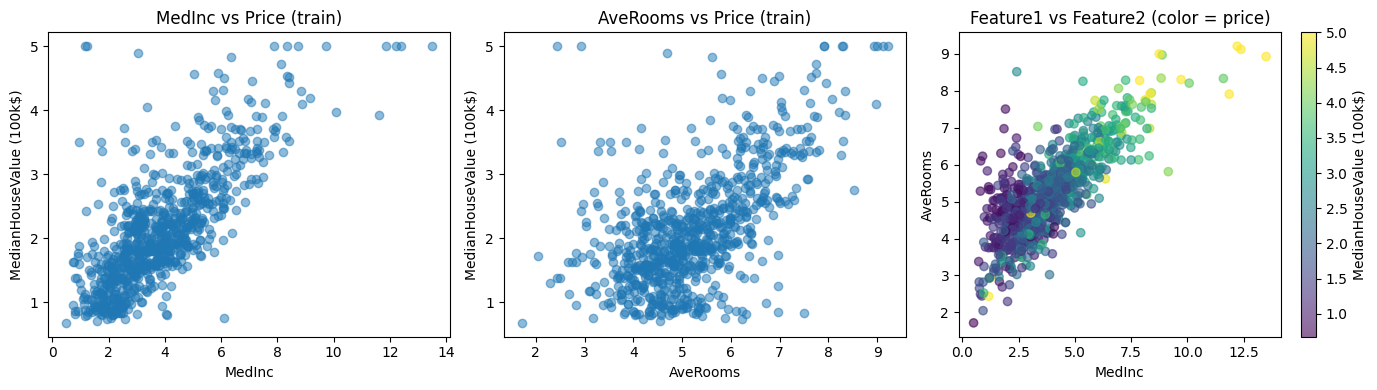

In [2]:
from sklearn.datasets import fetch_california_housing

cal_housing = fetch_california_housing()
X = cal_housing.data               # shape (n_samples, n_features)
y = cal_housing.target.reshape(-1, 1)  # median house value (in 100k$), shape (n_samples,1)
feature_names = cal_housing.feature_names
print("All features:", feature_names)

# I'll pick 'MedInc' (median income) and 'AveRooms' (average rooms per household).
# Change these indices/names if you prefer other features.
feat1_name = "MedInc"
feat2_name = "AveRooms"
feat1_idx = feature_names.index(feat1_name)
feat2_idx = feature_names.index(feat2_name)

X_two = X[:, [feat1_idx, feat2_idx]]  # shape (n_samples, 2)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_two[:1000], dtype=torch.float32)
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

print(f"Training X shape: {X_train.shape}")
print(f"Testing  X shape: {X_test.shape}")
print(f"Training y shape: {y_train.shape}")



# 1) Feature 1 vs Price
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_train[:, 0].numpy(), y_train.numpy(), alpha=0.5)
plt.xlabel(feat1_name)
plt.ylabel('MedianHouseValue (100k$)')
plt.title(f'{feat1_name} vs Price (train)')

# 2) Feature 2 vs Price
plt.subplot(1, 3, 2)
plt.scatter(X_train[:, 1].numpy(), y_train.numpy(), alpha=0.5)
plt.xlabel(feat2_name)
plt.ylabel('MedianHouseValue (100k$)')
plt.title(f'{feat2_name} vs Price (train)')

# 3) Feature1 vs Feature2 colored by price
plt.subplot(1, 3, 3)
sc = plt.scatter(X_train[:, 0].numpy(), X_train[:, 1].numpy(),
                 c=y_train.numpy().ravel(), alpha=0.6)
plt.xlabel(feat1_name)
plt.ylabel(feat2_name)
plt.title('Feature1 vs Feature2 (color = price)')
plt.colorbar(sc, label='MedianHouseValue (100k$)')

plt.tight_layout()
plt.show()


#### 1.2.2. Logistic Regression Data (Breast Cancer Wisconsin)


In [17]:
# Load the dataset
cancer = load_breast_cancer()
X_log = cancer.data
y_log = cancer.target.reshape(-1, 1)

# Scale the features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Convert to PyTorch tensors
X_log_tensor = torch.tensor(X_log_scaled, dtype=torch.float32)
y_log_tensor = torch.tensor(y_log, dtype=torch.float32)

# Split data
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log_tensor, y_log_tensor, test_size=0.2, random_state=42
)

print(f"Logistic Regression Training Data Shape: {X_train_log.shape}")
print(f"Logistic Regression Testing Data Shape: {X_test_log.shape}")
print(f"Feature Names: {cancer.feature_names[:5]}...")


Logistic Regression Training Data Shape: torch.Size([455, 30])
Logistic Regression Testing Data Shape: torch.Size([114, 30])
Feature Names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']...


## 2. Linear Regression: Implementation from Scratch

### 2.1. Model, Loss, and Gradient Calculation

We define the core components of our linear model:
*   **Hypothesis ($h$):** $y = XW + b$
*   **Loss Function (Mean Squared Error - MSE):** $L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
*   **Gradients:**
    *   $\frac{\partial L}{\partial W} = \frac{2}{N} X^T (\hat{y} - y)$
    *   $\frac{\partial L}{\partial b} = \frac{2}{N} \sum (\hat{y} - y)$


In [4]:
# Initialize parameters
input_size = X_train.shape[1]
output_size = 1
W_scratch = torch.randn(input_size, output_size, requires_grad=True)
b_scratch = torch.randn(output_size, requires_grad=True)

def linear_model_scratch(X):
    return X @ W_scratch + b_scratch

def mse_loss_scratch(y_pred, y_true):
    return torch.mean((y_pred - y_true)**2)

# Hyperparameters
learning_rate = 0.0001
num_epochs = 100

# Function to perform a single step of Gradient Descent
def gradient_descent_step(X, y, W, b, lr):
    # Forward pass
    y_pred = X @ W + b
    loss = mse_loss_scratch(y_pred, y)

    # Backward pass (Manual Gradient Calculation)
    error = y_pred - y
    grad_W = (2 / len(X)) * X.T @ error
    grad_b = (2 / len(X)) * torch.sum(error)

    # Update parameters
    with torch.no_grad():
        W -= lr * grad_W
        b -= lr * grad_b

    return loss.item()


### 2.2. Optimization Strategy 1: Batch Gradient Descent (BGD)

**Concept:** The gradient is calculated using the **entire** training dataset in each iteration. This is slow but guarantees convergence to the global minimum for convex functions.


Epoch [1/10000], Loss: 3.899558
Epoch [1000/10000], Loss: 2.560508
Epoch [2000/10000], Loss: 1.902313
Epoch [3000/10000], Loss: 1.464466
Epoch [4000/10000], Loss: 1.172792
Epoch [5000/10000], Loss: 0.978092
Epoch [6000/10000], Loss: 0.847733
Epoch [7000/10000], Loss: 0.760068
Epoch [8000/10000], Loss: 0.700740
Epoch [9000/10000], Loss: 0.660225
Epoch [10000/10000], Loss: 0.632206


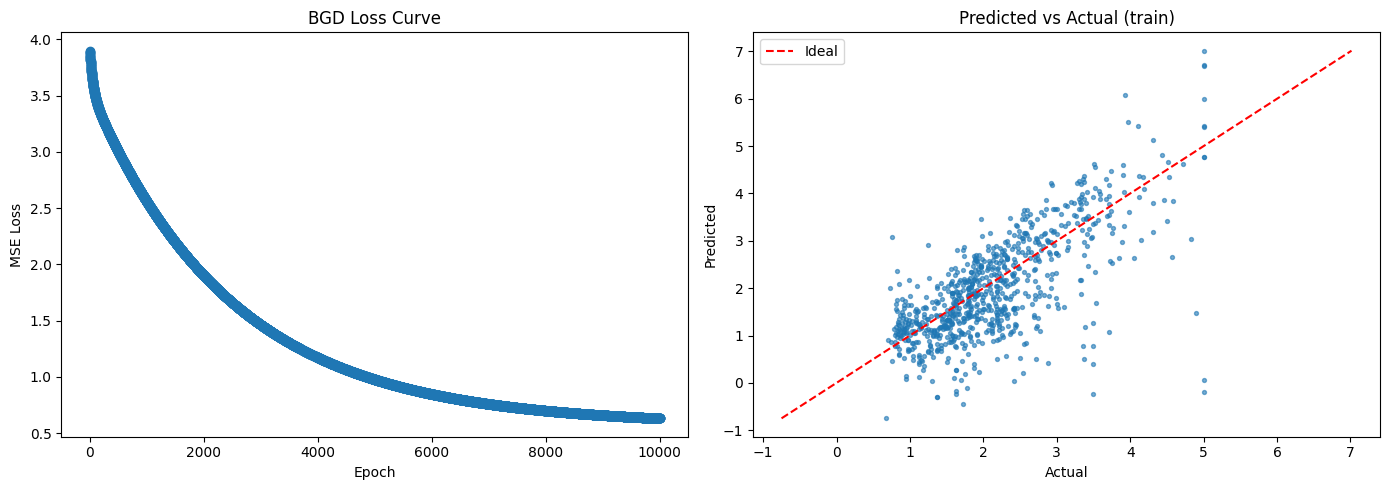

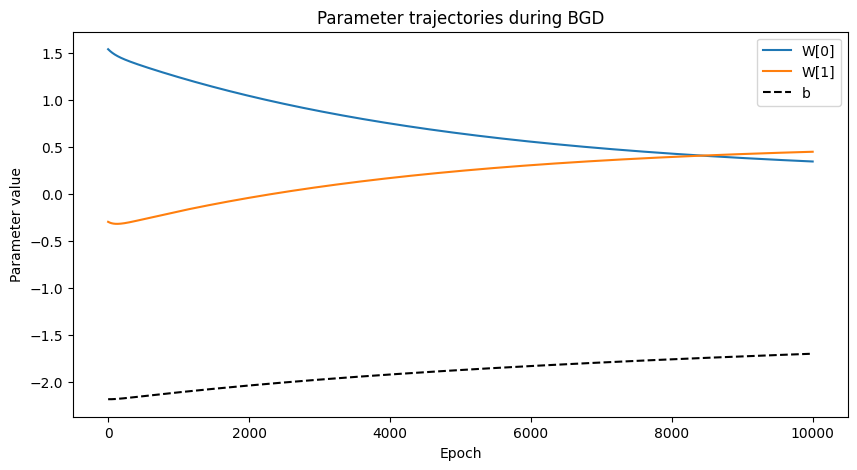

In [8]:
# Ensure shapes
# X_train: [N, input_size], y_train: [N, 1]
N, input_size = X_train.shape
output_size = 1

# Re-initialize parameters (as column vector for W)
torch.manual_seed(0)
W_bgd = torch.randn(input_size, output_size, dtype=torch.float32)  # shape [in, 1]
b_bgd = torch.randn(1, dtype=torch.float32)                        # shape [1]
lr_bgd = 1e-4
epochs_bgd = 10000

# Histories
loss_history_bgd = []
W_history_bgd = []   # store as np arrays
b_history_bgd = []

for epoch in range(epochs_bgd):
    # Batch is full dataset (BGD)
    X_batch, y_batch = X_train, y_train  # shapes: [N, in], [N,1]
    
    # Forward pass (matrix multiply)
    # y_pred shape: [N,1]
    y_pred = X_batch @ W_bgd + b_bgd
    
    # Compute loss (call the user's mse_loss_scratch)
    loss = mse_loss_scratch(y_pred, y_batch)  # should be scalar tensor
    
    # Manual gradients (closed-form for MSE wrt W and b)
    error = y_pred - y_batch                  # [N,1]
    grad_W = (2.0 / N) * (X_batch.T @ error)  # [in,1]
    grad_b = (2.0 / N) * torch.sum(error, dim=0)  # [1] shape
    
    # Update parameters (in-place subtraction)
    W_bgd = W_bgd - lr_bgd * grad_W
    b_bgd = b_bgd - lr_bgd * grad_b.squeeze()
    
    # Store history (convert to numpy for plotting later)
    loss_history_bgd.append(loss.item())
    W_history_bgd.append(W_bgd.detach().numpy().copy())  # shape [in,1]
    b_history_bgd.append(b_bgd.detach().numpy().copy())  # shape [1]
    
    if (epoch + 1) % 1000 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{epochs_bgd}], Loss: {loss.item():.6f}')
        
# Visualization of BGD
plt.figure(figsize=(14, 5))

# 1) Loss curve
plt.subplot(1, 2, 1)
plt.plot(loss_history_bgd, marker='o')
plt.title('BGD Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

# 2) Predicted vs Actual scatter (works for multi-feature)
# Compute predictions on train set
with torch.no_grad():
    y_train_pred = (X_train @ W_bgd + b_bgd).numpy().ravel()
    y_train_true = y_train.numpy().ravel()

plt.subplot(1, 2, 2)
plt.scatter(y_train_true, y_train_pred, alpha=0.6, s=8)
minv = min(y_train_true.min(), y_train_pred.min())
maxv = max(y_train_true.max(), y_train_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--', label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual (train)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot initial and final lines
initial_W = W_history_bgd[0]
initial_b = b_bgd.numpy() - (lr_bgd * grad_b.numpy()) # Approximate initial b
final_W = W_bgd.numpy()
final_b = b_bgd.numpy()

W_hist_arr = np.concatenate([w.reshape(1, -1) for w in W_history_bgd], axis=0)  # shape [epochs, input_size]
b_hist_arr = np.array(b_history_bgd).reshape(-1)

plt.figure(figsize=(10, 5))
for i in range(input_size):
    plt.plot(W_hist_arr[:, i], label=f'W[{i}]')
plt.plot(b_hist_arr, '--', label='b', color='black')
plt.xlabel('Epoch')
plt.ylabel('Parameter value')
plt.title('Parameter trajectories during BGD')
plt.legend()
plt.show()

### 2.3. Optimization Strategy 2: Stochastic Gradient Descent (SGD)

**Concept:** The gradient is calculated using only **one** data point (a batch size of 1) in each iteration. This introduces high variance but is very fast and can escape local minima (though not an issue for linear regression).


Epoch [1/5], Last Sample Loss: 0.280374
Epoch [2/5], Last Sample Loss: 0.293494
Epoch [3/5], Last Sample Loss: 0.306812
Epoch [4/5], Last Sample Loss: 0.318190
Epoch [5/5], Last Sample Loss: 0.327850


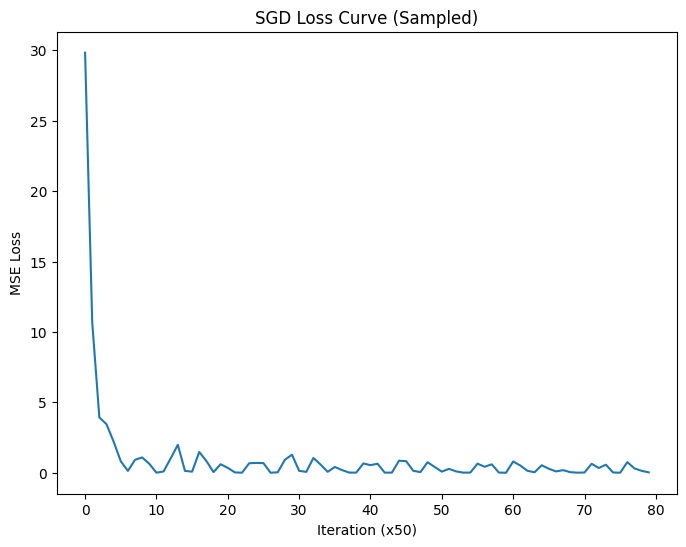

In [9]:
W_sgd = torch.randn(input_size, output_size)
b_sgd = torch.zeros(output_size)
lr_sgd = 1e-4  # smaller to start
epochs_sgd = 5

loss_history_sgd = []

for epoch in range(epochs_sgd):
    for i in range(len(X_train)):
        X_sample = X_train[i:i+1]   # shape (1, input_size)
        y_sample = y_train[i:i+1]   # shape (1, output_size)

        # Forward pass
        y_pred = X_sample @ W_sgd + b_sgd  # shapes broadcast: (1,output_size)

        loss = mse_loss_scratch(y_pred, y_sample)

        # Check for NaN/Inf immediately
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf loss at epoch {epoch}, sample {i}")
            print("y_pred:", y_pred)
            print("y_sample:", y_sample)
            print("W stats:", W_sgd.mean().item(), W_sgd.std().item())
            print("b stats:", b_sgd.mean().item(), b_sgd.std().item())
            raise RuntimeError("Stopping due to NaN/Inf loss")

        # Manual gradient for batch size = 1
        error = y_pred - y_sample  # shape (1, output_size)
        # grad_W shape should be (input_size, output_size)
        grad_W = 2.0 * X_sample.T @ error   # (input_size, 1) @ (1, output_size) -> (input_size, output_size)
        # grad_b should match b_sgd shape (output_size,)
        grad_b = 2.0 * error.sum(dim=0)     # sum over batch -> shape (output_size,)

        # Optional: gradient clipping for stability
        torch.clamp_(grad_W, -1e3, 1e3)
        torch.clamp_(grad_b, -1e3, 1e3)

        # Update (in-place)
        W_sgd = W_sgd - lr_sgd * grad_W
        b_sgd = b_sgd - lr_sgd * grad_b

        loss_history_sgd.append(loss.item())

    print(f'Epoch [{epoch+1}/{epochs_sgd}], Last Sample Loss: {loss.item():.6f}')


# Visualization of SGD Loss (Note the high variance)
plt.figure(figsize=(8, 6))
plt.plot(loss_history_sgd[::50]) # Plot every 50th step for better visualization
plt.title('SGD Loss Curve (Sampled)')
plt.xlabel('Iteration (x50)')
plt.ylabel('MSE Loss')
plt.show()

### 2.4. Optimization Strategy 3: Mini-Batch Gradient Descent (MBGD)

**Concept:** The gradient is calculated using a small subset of the data (the mini-batch). This balances the stability of BGD with the speed of SGD. This is the most common approach in deep learning.


Epoch [10/50], Loss: 2.4902
Epoch [20/50], Loss: 2.2512
Epoch [30/50], Loss: 1.1496
Epoch [40/50], Loss: 1.4077
Epoch [50/50], Loss: 0.9973


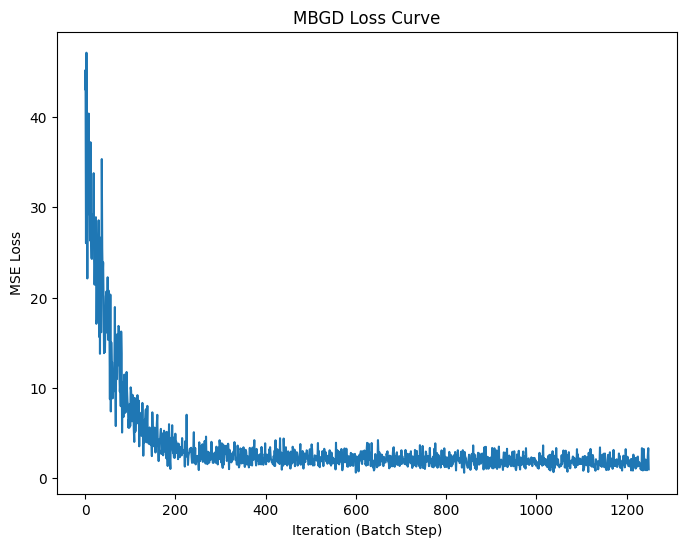

In [10]:
# Re-initialize parameters for MBGD
W_mbgd = torch.randn(input_size, output_size)
b_mbgd = torch.zeros(output_size)
lr_mbgd = 1e-4
epochs_mbgd = 50
batch_size = 32 # A common mini-batch size

# Create a PyTorch DataLoader for easy batching
from torch.utils.data import TensorDataset, DataLoader
train_data_lin = TensorDataset(X_train, y_train)
train_loader_lin = DataLoader(train_data_lin, batch_size=batch_size, shuffle=True)

# Training loop for MBGD
loss_history_mbgd = []

for epoch in range(epochs_mbgd):
    for i, (X_batch, y_batch) in enumerate(train_loader_lin):
        # Forward pass
        y_pred = X_batch @ W_mbgd + b_mbgd
        loss = mse_loss_scratch(y_pred, y_batch)

        # immediate check
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf loss at epoch {epoch}, batch {i}")
            print("y_pred stats:", y_pred.mean().item(), y_pred.std().item())
            print("y_batch stats:", y_batch.mean().item(), y_batch.std().item())
            raise RuntimeError("Stopping due to NaN/Inf loss")

        # Manual Gradient Calculation
        n = X_batch.shape[0]
        error = y_pred - y_batch
        grad_W = (2.0 / n) * (X_batch.T @ error) 
        grad_b = (2.0 / n) * error.sum(dim=0)  

        # Update parameters
        W_mbgd -= lr_mbgd * grad_W
        b_mbgd -= lr_mbgd * grad_b

        loss_history_mbgd.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs_mbgd}], Loss: {loss.item():.4f}')

# Visualization of MBGD Loss
plt.figure(figsize=(8, 6))
plt.plot(loss_history_mbgd)
plt.title('MBGD Loss Curve')
plt.xlabel('Iteration (Batch Step)')
plt.ylabel('MSE Loss')
plt.show()


## 3. Logistic Regression: Implementation from Scratch

### 3.1. Activation Functions: Sigmoid and Softmax

**Concept:**
*   **Sigmoid ($\sigma$):** Maps any real-valued number to a value between 0 and 1. It is used in **binary classification** to output a probability.
    $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
*   **Softmax:** Maps a vector of real numbers to a probability distribution. It is used in **multi-class classification** to output a probability for each class.
    $$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$


In [11]:
def sigmoid_scratch(z):
    return 1 / (1 + torch.exp(-z))

def softmax_scratch(z):
    # Subtract max for numerical stability
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

# Example Usage
z_example = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32).reshape(1, -1)
print(f"Input: {z_example.numpy()}")
print(f"Sigmoid Output: {sigmoid_scratch(z_example).numpy()}")
print(f"Softmax Output: {softmax_scratch(z_example).numpy()}")
print(f"Softmax Sum: {softmax_scratch(z_example).sum(dim=1).item()}")


Input: [[1. 2. 3.]]
Sigmoid Output: [[0.7310586  0.880797   0.95257413]]
Softmax Output: [[0.09003057 0.24472848 0.66524094]]
Softmax Sum: 1.0


### 3.2. Model, Loss, and Gradient Calculation

We use the Breast Cancer dataset for binary classification.

*   **Hypothesis ($h$):** $\hat{y} = \sigma(XW + b)$
*   **Loss Function (Binary Cross-Entropy - BCE):** $L = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)]$


Epoch [100/1000], Loss: 0.5142, Test Accuracy: 0.9737
Epoch [200/1000], Loss: 0.2366, Test Accuracy: 0.9825
Epoch [300/1000], Loss: 0.1231, Test Accuracy: 0.9825
Epoch [400/1000], Loss: 0.2069, Test Accuracy: 0.9825
Epoch [500/1000], Loss: 0.1642, Test Accuracy: 0.9825
Epoch [600/1000], Loss: 0.1597, Test Accuracy: 0.9825
Epoch [700/1000], Loss: 0.1745, Test Accuracy: 0.9825
Epoch [800/1000], Loss: 0.3156, Test Accuracy: 0.9825
Epoch [900/1000], Loss: 0.0293, Test Accuracy: 0.9825
Epoch [1000/1000], Loss: 0.0158, Test Accuracy: 0.9912

Selected Top 2 Features for Visualization:
1. worst perimeter (Index: 22)
2. worst radius (Index: 20)


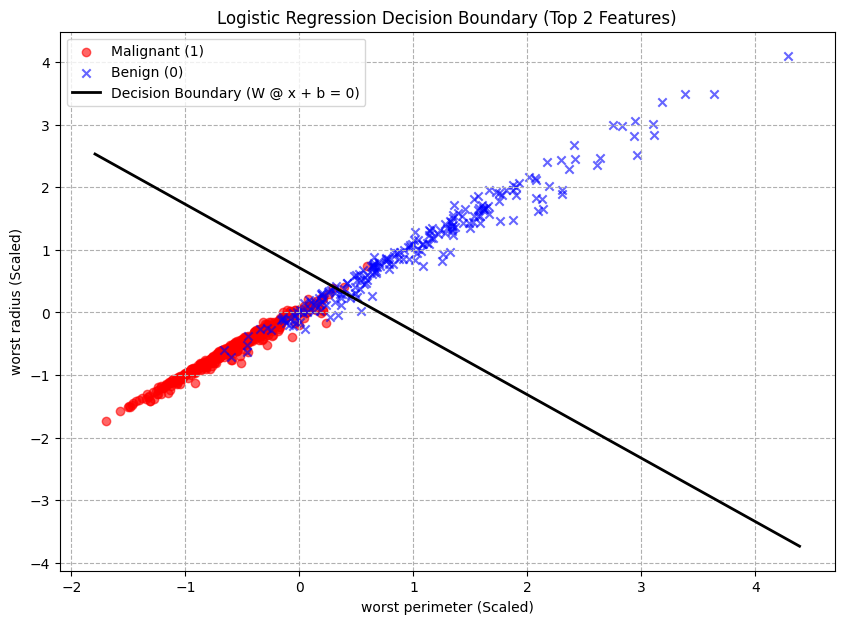


--- Model Training Loss ---


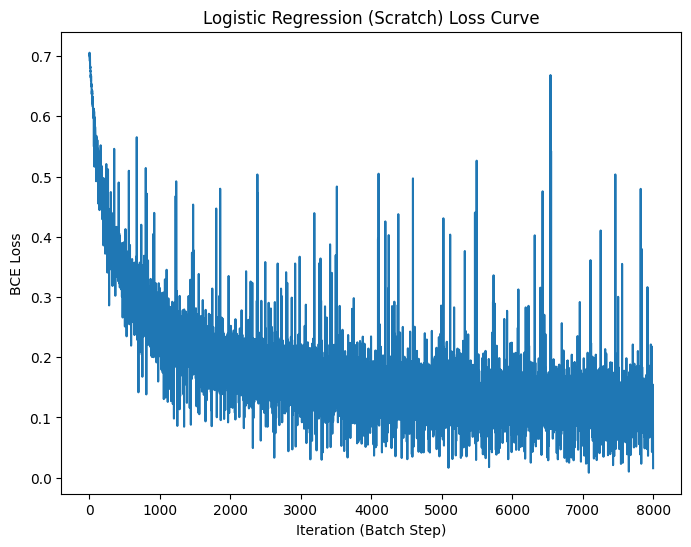

In [25]:
# Initialize parameters
input_size_log = X_train_log.shape[1]
output_size_log = 1
W_log_scratch = torch.randn(input_size_log, output_size_log, requires_grad=False) * 0.01
b_log_scratch = torch.zeros(output_size_log, requires_grad=False)

def logistic_model_scratch(X):
    linear_output = X @ W_log_scratch + b_log_scratch
    return sigmoid_scratch(linear_output)

def bce_loss_scratch(y_pred, y_true):
    # Add a small epsilon to prevent log(0)
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

# Hyperparameters
lr_log = 0.001
epochs_log = 1000

# Training loop for Logistic Regression (using Mini-Batch GD)
batch_size_log = 64
train_data_log = TensorDataset(X_train_log, y_train_log)
train_loader_log = DataLoader(train_data_log, batch_size=batch_size_log, shuffle=True)
loss_history_log = []

for epoch in range(epochs_log):
    for i, (X_batch, y_batch) in enumerate(train_loader_log):
        # Forward pass
        y_pred = logistic_model_scratch(X_batch)
        loss = bce_loss_scratch(y_pred, y_batch)

        # Manual Gradient Calculation
        # dL/dW = (1/N) * X^T * (y_pred - y_true)
        error = y_pred - y_batch
        grad_W = (1 / len(X_batch)) * X_batch.T @ error
        grad_b = (1 / len(X_batch)) * torch.sum(error)

        # Update parameters
        W_log_scratch -= lr_log * grad_W
        b_log_scratch -= lr_log * grad_b

        loss_history_log.append(loss.item())

    if (epoch + 1) % 100 == 0:
        # Calculate accuracy
        with torch.no_grad():
            y_pred_test = logistic_model_scratch(X_test_log)
            y_pred_class = (y_pred_test >= 0.5).float()
            accuracy = (y_pred_class == y_test_log).sum().item() / len(y_test_log)
        print(f'Epoch [{epoch+1}/{epochs_log}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}')

## 1. Select the Top Two Features
# The magnitude of the learned weights (W) in a linear model like Logistic Regression 
# is a good proxy for feature importance, assuming scaled features.
W_abs = torch.abs(W_log_scratch).squeeze()
# Get the indices of the top 2 features
top_2_indices = torch.argsort(W_abs, descending=True)[:2].tolist()

# Get the names of the selected features
feature_names = cancer.feature_names
feature_1_index = top_2_indices[0]
feature_2_index = top_2_indices[1]
feature_1_name = feature_names[feature_1_index]
feature_2_name = feature_names[feature_2_index]

print(f"\nSelected Top 2 Features for Visualization:")
print(f"1. {feature_1_name} (Index: {feature_1_index})")
print(f"2. {feature_2_name} (Index: {feature_2_index})")

## 2. Extract Data for Visualization
# Slice the original scaled data to keep only the two selected features
X_2d = X_log_tensor[:, top_2_indices].numpy()
y_2d = y_log_tensor.squeeze().numpy()

## 3. Define the Decision Boundary
# The decision boundary for Logistic Regression is where the linear output is 0:
# W_1*x_1 + W_2*x_2 + ... + W_n*x_n + b = 0
# For the 2D plot (assuming we ignore the effect of other features for a simple plane visualization):
# W_1*x_1 + W_2*x_2 + b = 0
# We solve for x_2 (the y-axis) in terms of x_1 (the x-axis):
# x_2 = (-W_1/W_2) * x_1 - (b/W_2)

W1 = W_log_scratch[feature_1_index].item()
W2 = W_log_scratch[feature_2_index].item()
b = b_log_scratch.item()

# Get the min and max values of the first feature for the line plot range
x_min, x_max = X_2d[:, 0].min() - 0.1, X_2d[:, 0].max() + 0.1
x_db = np.array([x_min, x_max])

# Calculate the corresponding y values for the decision boundary line
# y = m*x + c, where m = -W1/W2 and c = -b/W2
y_db = (-W1 / W2) * x_db - (b / W2)

## 4. Plotting the Results
plt.figure(figsize=(10, 7))

# Scatter plot the data points
# Points with y=1 (Malignant) are plotted in Red
plt.scatter(
    X_2d[y_2d == 1, 0],
    X_2d[y_2d == 1, 1],
    color='red',
    label='Malignant (1)',
    marker='o',
    alpha=0.6
)
# Points with y=0 (Benign) are plotted in Blue
plt.scatter(
    X_2d[y_2d == 0, 0],
    X_2d[y_2d == 0, 1],
    color='blue',
    label='Benign (0)',
    marker='x',
    alpha=0.6
)

# Plot the decision boundary line
plt.plot(
    x_db,
    y_db,
    color='black',
    linestyle='-',
    linewidth=2,
    label='Decision Boundary (W @ x + b = 0)'
)

plt.title('Logistic Regression Decision Boundary (Top 2 Features)')
plt.xlabel(f'{feature_1_name} (Scaled)')
plt.ylabel(f'{feature_2_name} (Scaled)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

print("\n--- Model Training Loss ---")
# Visualization of Logistic Regression Loss
plt.figure(figsize=(8, 6))
plt.plot(loss_history_log)
plt.title('Logistic Regression (Scratch) Loss Curve')
plt.xlabel('Iteration (Batch Step)')
plt.ylabel('BCE Loss')
plt.show()

## 4. Overfitting, Underfitting, and Regularization

### 4.1. Overfitting Demonstration (Linear Regression)

**Concept:** Overfitting occurs when a model learns the training data too well, including the noise, leading to poor generalization on unseen data. We will simulate this by using a high-degree polynomial feature expansion on a small dataset.


Overfit Model: Train Loss = 553.7369, Test Loss = 11390.0117


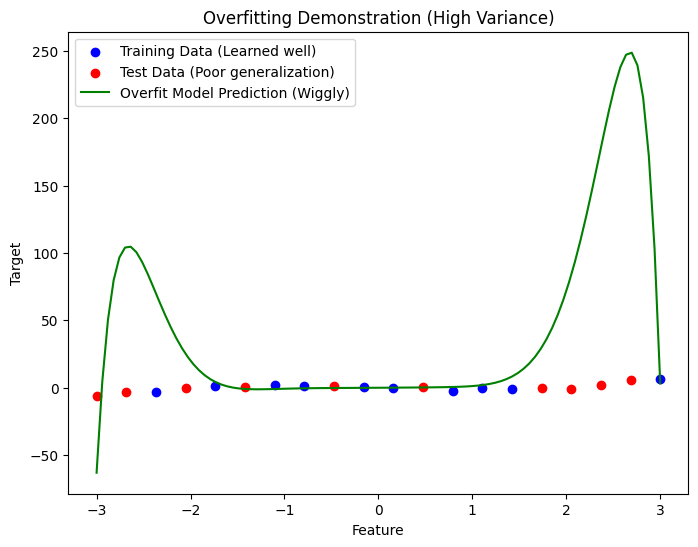

In [73]:
# 1. Create a small, noisy dataset
np.random.seed(10)
X_overfit = np.linspace(-3, 3, 20).reshape(-1, 1)
y_overfit = 0.5 * X_overfit**3 - 2 * X_overfit + np.random.normal(0, 1, X_overfit.shape)
X_overfit_tensor = torch.tensor(X_overfit, dtype=torch.float32)
y_overfit_tensor = torch.tensor(y_overfit, dtype=torch.float32)

# Split into tiny train/test sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_overfit_tensor, y_overfit_tensor, test_size=0.5, random_state=42
)

# 2. High-Degree Polynomial Feature Expansion (Degree 10)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=10)
X_train_poly = torch.tensor(poly.fit_transform(X_train_over.numpy()), dtype=torch.float32)
X_test_poly = torch.tensor(poly.transform(X_test_over.numpy()), dtype=torch.float32)

# 3. Train a Linear Model (PyTorch Library for simplicity here)
class PolyModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

model_overfit = PolyModel(X_train_poly.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_overfit.parameters(), lr=0.0001)
epochs_overfit = 5000

for epoch in range(epochs_overfit):
    y_pred = model_overfit(X_train_poly)
    loss = criterion(y_pred, y_train_over)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 4. Visualization of Overfitting
model_overfit.eval()
with torch.no_grad():
    # Generate points for smooth curve
    X_range = torch.linspace(-3, 3, 100).reshape(-1, 1)
    X_range_poly = torch.tensor(poly.transform(X_range.numpy()), dtype=torch.float32)
    y_pred_range = model_overfit(X_range_poly)

    train_loss = criterion(model_overfit(X_train_poly), y_train_over).item()
    test_loss = criterion(model_overfit(X_test_poly), y_test_over).item()

print(f"Overfit Model: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_train_over.numpy(), y_train_over.numpy(), label='Training Data (Learned well)', color='blue')
plt.scatter(X_test_over.numpy(), y_test_over.numpy(), label='Test Data (Poor generalization)', color='red')
plt.plot(X_range.numpy(), y_pred_range.numpy(), 'g-', label='Overfit Model Prediction (Wiggly)')
plt.title('Overfitting Demonstration (High Variance)')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()


### 4.2. Underfitting Demonstration (Linear Regression)

**Concept:** Underfitting occurs when a model is too simple to capture the underlying structure of the data (high bias). We use a simple linear model on the complex polynomial data.


Underfit Model: Train Loss = 5.2819, Test Loss = 4.9822


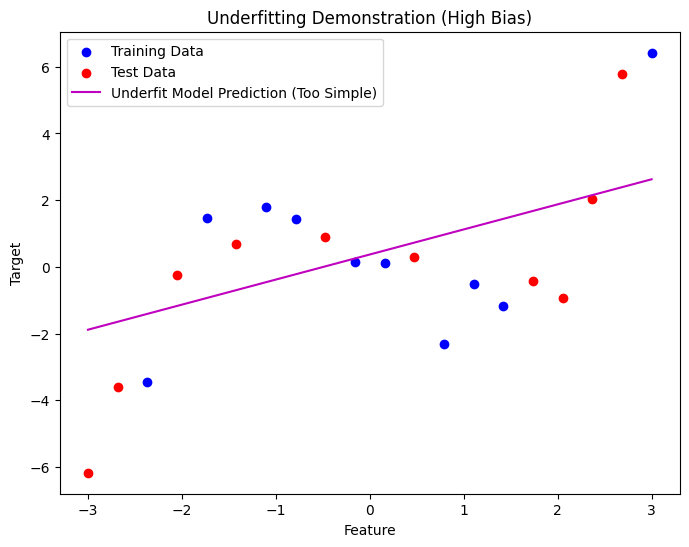

In [68]:
# 1. Train a simple Linear Model (Degree 1) on the complex data
model_underfit = PolyModel(X_train_over.shape[1]) # Only one feature (degree 1)
optimizer_underfit = optim.SGD(model_underfit.parameters(), lr=0.01)
epochs_underfit = 1000

# Use only the original, non-polynomial features
X_train_simple = X_train_over
X_test_simple = X_test_over

for epoch in range(epochs_underfit):
    y_pred = model_underfit(X_train_simple)
    loss = criterion(y_pred, y_train_over)
    optimizer_underfit.zero_grad()
    loss.backward()
    optimizer_underfit.step()

# 2. Visualization of Underfitting
model_underfit.eval()
with torch.no_grad():
    X_range = torch.linspace(-3, 3, 100).reshape(-1, 1)
    y_pred_range = model_underfit(X_range)

    train_loss = criterion(model_underfit(X_train_simple), y_train_over).item()
    test_loss = criterion(model_underfit(X_test_simple), y_test_over).item()

print(f"Underfit Model: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_train_over.numpy(), y_train_over.numpy(), label='Training Data', color='blue')
plt.scatter(X_test_over.numpy(), y_test_over.numpy(), label='Test Data', color='red')
plt.plot(X_range.numpy(), y_pred_range.numpy(), 'm-', label='Underfit Model Prediction (Too Simple)')
plt.title('Underfitting Demonstration (High Bias)')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()


### 4.3. Regularization (L1 and L2)

**Concept:** Regularization adds a penalty term to the loss function to discourage large weights, which helps to simplify the model and reduce overfitting.

*   **L2 Regularization (Ridge):** Penalty is proportional to the square of the weights ($\sum W^2$). It drives weights towards zero but rarely to exactly zero.
*   **L1 Regularization (Lasso):** Penalty is proportional to the absolute value of the weights ($\sum |W|$). It can drive some weights to exactly zero, performing feature selection.

#### 4.3.1. L2 Regularization (Ridge) on Overfit Model


L2 Regularized Model: Train Loss = 5.6493, Test Loss = 20257.5039


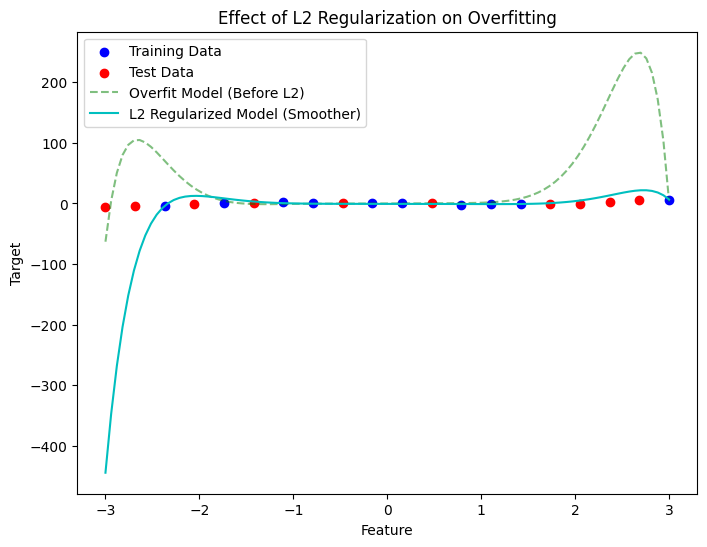

In [82]:
# Re-initialize the overfit model
model_l2 = PolyModel(X_train_poly.shape[1])
criterion = nn.MSELoss()
# Use PyTorch's built-in weight_decay for L2 regularization
l2_lambda = 0.001
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=l2_lambda)
epochs_l2 = 5000

for epoch in range(epochs_l2):
    y_pred = model_l2(X_train_poly)
    loss = criterion(y_pred, y_train_over)
    optimizer_l2.zero_grad()
    loss.backward()
    optimizer_l2.step()

# Visualization of L2 Effect
model_l2.eval()
with torch.no_grad():
    X_range = torch.linspace(-3, 3, 100).reshape(-1, 1)
    X_range_poly = torch.tensor(poly.transform(X_range.numpy()), dtype=torch.float32)
    y_pred_range_l2 = model_l2(X_range_poly)

    train_loss_l2 = criterion(model_l2(X_train_poly), y_train_over).item()
    test_loss_l2 = criterion(model_l2(X_test_poly), y_test_over).item()

print(f"L2 Regularized Model: Train Loss = {train_loss_l2:.4f}, Test Loss = {test_loss_l2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_train_over.numpy(), y_train_over.numpy(), label='Training Data', color='blue')
plt.scatter(X_test_over.numpy(), y_test_over.numpy(), label='Test Data', color='red')
plt.plot(X_range.numpy(), y_pred_range.numpy(), 'g--', alpha=0.5, label='Overfit Model (Before L2)')
plt.plot(X_range.numpy(), y_pred_range_l2.numpy(), 'c-', label='L2 Regularized Model (Smoother)')
plt.title('Effect of L2 Regularization on Overfitting')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()


#### 4.3.2. L1 Regularization (Lasso) on Overfit Model

*Note: PyTorch's built-in optimizers do not have a direct L1 `weight_decay` parameter, so we must implement the L1 penalty manually.*


L1 Regularized Model: Train Loss = 168.0677, Test Loss = 350566.5312


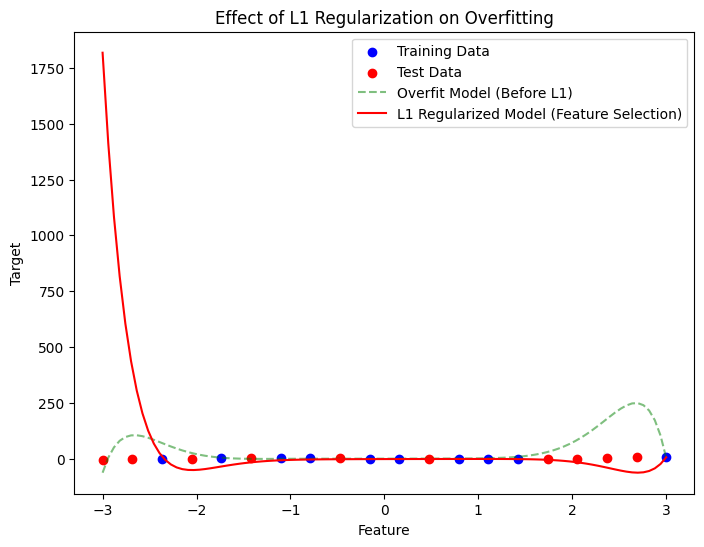

In [85]:
# Re-initialize the overfit model
model_l1 = PolyModel(X_train_poly.shape[1])
criterion = nn.MSELoss()
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.001)
epochs_l1 = 5000
l1_lambda = 0.01

for epoch in range(epochs_l1):
    y_pred = model_l1(X_train_poly)
    mse_loss = criterion(y_pred, y_train_over)

    # Manual L1 Regularization Term
    l1_norm = sum(torch.abs(p).sum() for p in model_l1.parameters())
    total_loss = mse_loss + l1_lambda * l1_norm

    optimizer_l1.zero_grad()
    total_loss.backward()
    optimizer_l1.step()

# Visualization of L1 Effect
model_l1.eval()
with torch.no_grad():
    X_range = torch.linspace(-3, 3, 100).reshape(-1, 1)
    X_range_poly = torch.tensor(poly.transform(X_range.numpy()), dtype=torch.float32)
    y_pred_range_l1 = model_l1(X_range_poly)

    train_loss_l1 = criterion(model_l1(X_train_poly), y_train_over).item()
    test_loss_l1 = criterion(model_l1(X_test_poly), y_test_over).item()

print(f"L1 Regularized Model: Train Loss = {train_loss_l1:.4f}, Test Loss = {test_loss_l1:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_train_over.numpy(), y_train_over.numpy(), label='Training Data', color='blue')
plt.scatter(X_test_over.numpy(), y_test_over.numpy(), label='Test Data', color='red')
plt.plot(X_range.numpy(), y_pred_range.numpy(), 'g--', alpha=0.5, label='Overfit Model (Before L1)')
plt.plot(X_range.numpy(), y_pred_range_l1.numpy(), 'r-', label='L1 Regularized Model (Feature Selection)')
plt.title('Effect of L1 Regularization on Overfitting')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()


## 5. PyTorch Library Implementation

### 5.1. Linear Regression with PyTorch Modules

**Concept:** PyTorch provides the `nn.Linear` module for the model and `optim.Adam` for the optimizer, which handles the gradient calculation and parameter updates automatically.


Epoch [20/100], Loss: 919.2689
Epoch [40/100], Loss: 1352.0703
Epoch [60/100], Loss: 817.0553
Epoch [80/100], Loss: 1262.3629
Epoch [100/100], Loss: 1583.2773
Library Model Test Loss: 1004.0461


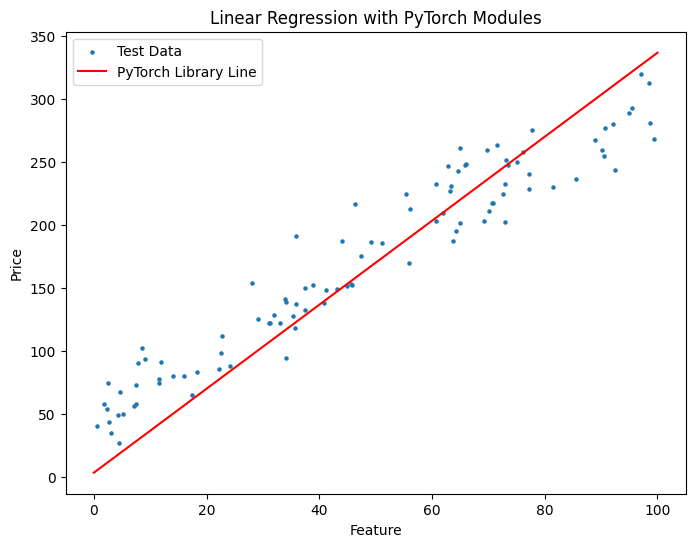

In [ ]:
# 1. Define the Model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# 2. Setup
model_lib = LinearRegression(X_train.shape[1], 1)
criterion_lib = nn.MSELoss()
optimizer_lib = optim.SGD(model_lib.parameters(), lr=0.0001)
epochs_lib = 100

# Use the same DataLoader from the scratch implementation
# train_loader_lin (Mini-Batch GD)

# 3. Training Loop
loss_history_lib = []
for epoch in range(epochs_lib):
    for X_batch, y_batch in train_loader_lin:
        # Forward pass
        y_pred = model_lib(X_batch)
        loss = criterion_lib(y_pred, y_batch)

        # Backward and optimize
        optimizer_lib.zero_grad()
        loss.backward()
        optimizer_lib.step()

        loss_history_lib.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs_lib}], Loss: {loss.item():.4f}')

# 4. Evaluation and Visualization
model_lib.eval()
with torch.no_grad():
    y_pred_test = model_lib(X_test)
    test_loss = criterion_lib(y_pred_test, y_test).item()
    print(f"Library Model Test Loss: {test_loss:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_test.numpy(), y_test.numpy(), label='Test Data', s=5)
x_range = torch.tensor([[0.0], [100.0]], dtype=torch.float32)
y_range_pred = model_lib(x_range)
plt.plot(x_range.numpy(), y_range_pred.detach().numpy(), 'r-', label='PyTorch Library Line')
plt.title('Linear Regression with PyTorch Modules')
plt.xlabel('Feature')
plt.ylabel('Price')
plt.legend()
plt.show()


### 5.2. Logistic Regression with PyTorch Modules

**Concept:** For logistic regression, we use `nn.Linear` followed by the `nn.Sigmoid` activation function. PyTorch's `nn.BCEWithLogitsLoss` is often preferred as it combines the sigmoid layer and the BCE loss for numerical stability.


Epoch [20/100], Loss: 0.1325, Test Accuracy: 0.9825
Epoch [40/100], Loss: 0.2377, Test Accuracy: 0.9825
Epoch [60/100], Loss: 0.1310, Test Accuracy: 0.9825
Epoch [80/100], Loss: 0.1439, Test Accuracy: 0.9912
Epoch [100/100], Loss: 0.0961, Test Accuracy: 0.9912


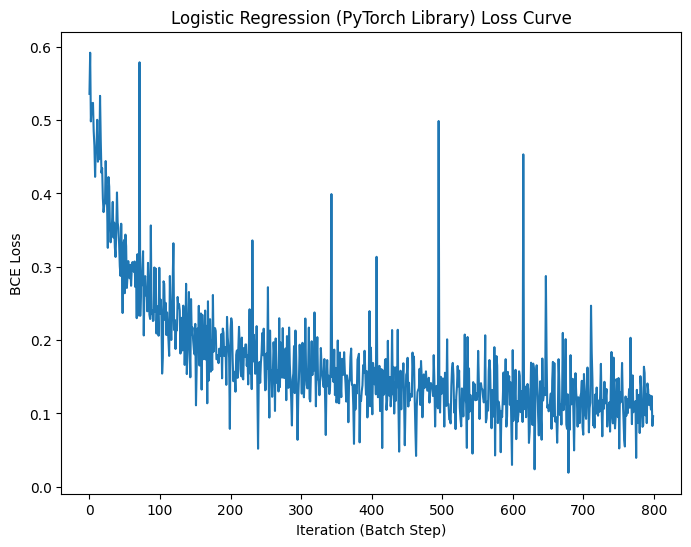

In [ ]:
# 1. Define the Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        # Note: We omit Sigmoid here and use BCEWithLogitsLoss for stability

    def forward(self, x):
        return self.linear(x)

# 2. Setup
model_log_lib = LogisticRegression(X_train_log.shape[1])

# sigmoid_out = torch.sigmoid(logits)
# loss = nn.BCELoss()(sigmoid_out, labels)
# nn.BCEWithLogitsLoss is numerically more stable than nn.BCELoss + nn.Sigmoid
criterion_log_lib = nn.BCEWithLogitsLoss()
optimizer_log_lib = optim.SGD(model_log_lib.parameters(), lr=0.01)
epochs_log_lib = 100

# Use the same DataLoader from the scratch implementation
# train_loader_log

# 3. Training Loop
loss_history_log_lib = []
for epoch in range(epochs_log_lib):
    for X_batch, y_batch in train_loader_log:
        # Forward pass
        y_logits = model_log_lib(X_batch)
        loss = criterion_log_lib(y_logits, y_batch)

        # Backward and optimize
        optimizer_log_lib.zero_grad()
        loss.backward()
        optimizer_log_lib.step()

        loss_history_log_lib.append(loss.item())

    if (epoch + 1) % 20 == 0:
        # Calculate accuracy
        with torch.no_grad():
            y_logits_test = model_log_lib(X_test_log)
            y_pred_prob = torch.sigmoid(y_logits_test)
            y_pred_class = (y_pred_prob >= 0.5).float()
            accuracy = (y_pred_class == y_test_log).sum().item() / len(y_test_log)
        print(f'Epoch [{epoch+1}/{epochs_log_lib}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}')

# 4. Visualization of Logistic Regression Loss
plt.figure(figsize=(8, 6))
plt.plot(loss_history_log_lib)
plt.title('Logistic Regression (PyTorch Library) Loss Curve')
plt.xlabel('Iteration (Batch Step)')
plt.ylabel('BCE Loss')
plt.show()


### 5.3. Softmax for Multi-Class Classification (Brief Example)

**Concept:** While our main example was binary, Softmax is crucial for multi-class problems. We will use a small subset of the Iris dataset to demonstrate its use with PyTorch's `nn.CrossEntropyLoss`.


In [93]:
# 1. Prepare Multi-Class Data (Iris)
from sklearn.datasets import load_iris
iris = load_iris()
X_multi = iris.data
y_multi = iris.target

# Scale and convert to tensors
X_multi_scaled = StandardScaler().fit_transform(X_multi)
X_multi_tensor = torch.tensor(X_multi_scaled, dtype=torch.float32)
# Target must be LongTensor for CrossEntropyLoss
y_multi_tensor = torch.tensor(y_multi, dtype=torch.long)

# Split data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi_tensor, y_multi_tensor, test_size=0.2, random_state=42
)

# 2. Define the Multi-Class Model
class MultiClassModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        # Note: Softmax is implicitly included in nn.CrossEntropyLoss

    def forward(self, x):
        return self.linear(x) # Output are logits

# 3. Setup and Training
model_multi = MultiClassModel(X_train_multi.shape[1], 3)
# nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss (Negative Log Likelihood Loss)
criterion_multi = nn.CrossEntropyLoss()
optimizer_multi = optim.SGD(model_multi.parameters(), lr=0.01)
epochs_multi = 100

for epoch in range(epochs_multi):
    # Forward pass
    y_logits = model_multi(X_train_multi)
    loss = criterion_multi(y_logits, y_train_multi)

    # Backward and optimize
    optimizer_multi.zero_grad()
    loss.backward()
    optimizer_multi.step()

# 4. Evaluation and Softmax Output
model_multi.eval()
with torch.no_grad():
    y_logits_test = model_multi(X_test_multi)
    # To get probabilities, we manually apply Softmax to the logits
    y_pred_prob = torch.softmax(y_logits_test, dim=1)
    _, y_pred_class = torch.max(y_logits_test, 1)
    accuracy = (y_pred_class == y_test_multi).sum().item() / len(y_test_multi)

print(f"\nMulti-Class Model Test Accuracy: {accuracy:.4f}")
print("\nExample Softmax Output (Probabilities for 3 classes):")
print(y_pred_prob[:5].numpy())
print("The sum of probabilities for each row is 1.0, as required by Softmax.")



Multi-Class Model Test Accuracy: 0.8333

Example Softmax Output (Probabilities for 3 classes):
[[0.17546143 0.40575984 0.41877878]
 [0.61896384 0.18479823 0.19623797]
 [0.0314955  0.3018236  0.66668093]
 [0.19236015 0.43029603 0.37734386]
 [0.11526232 0.36260653 0.52213115]]
The sum of probabilities for each row is 1.0, as required by Softmax.


## 6. Conclusion

This notebook has provided a hands-on journey through the fundamentals of regression and optimization. By implementing the models and gradient descent algorithms from scratch, you have gained a deep understanding of the underlying mathematics. By then transitioning to the PyTorch library, you have learned how to leverage powerful, optimized tools for real-world machine learning development.

**Key Takeaways:**
*   **Linear vs. Logistic Regression:** Linear predicts a continuous value; Logistic predicts a probability (classification).
*   **Gradient Descent Variants:** BGD is stable but slow; SGD is fast but noisy; MBGD is the practical balance.
*   **Overfitting/Underfitting:** Overfitting (high variance) is fixed by simplification (e.g., regularization); Underfitting (high bias) is fixed by making the model more complex.
*   **Regularization:** L1 and L2 penalize large weights to smooth the decision boundary and improve generalization.
*   **Activation Functions:** Sigmoid for binary probability; Softmax for multi-class probability distribution.
```
